<a href="https://colab.research.google.com/github/7aslan/TensorFlow_Practice/blob/main/Transfer_Learning_with_Tensorflow_Part1_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#What we're going to cover

We're going to go through the following with TensorFlow:

    Introduce transfer learning (a way to beat all of our old self-built models)
    Using a smaller dataset to experiment faster (10% of training samples of 10 classes of food)
    Build a transfer learning feature extraction model using TensorFlow Hub
    Introduce the TensorBoard callback to track model training results
    Compare model results using TensorBoard


In [1]:
# Add timestamp
import datetime
print(f"Notebook last run(end-to-end):{datetime.datetime.now()}")

Notebook last run(end-to-end):2023-08-01 12:28:43.484026


In [1]:
!nvidia-smi

Tue Aug  1 12:29:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Transfer learning often allows you to get great results with less data.

But don't just take my word for it. Let's download a subset of the data we've been using, namely 10% of the training data from the 10_food_classes dataset and use it to train a food image classifier on.

# Download and become one with data


In [3]:
# GEt data(10% of labels)
import zipfile
 #Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip","r")
zip_ref.extractall()
zip_ref.close()

--2023-08-01 12:37:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  23.9MB/s    in 8.0s    

2023-08-01 12:37:20 (20.0 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [4]:
# How many images  are in each folder ?
import os
# Walk through 10 percent data directory and list numbers of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c



Notice how each of the training directories now has 75 images rather than 750 images. This is key to demonstrating how well transfer learning can perform with less labelled images.

The test directories still have the same amount of images. This means we'll be training on less data but evaluating our models on the same amount of test data.


# Creating Data Loaders

Now we've downloaded the data, let's use the ImageDataGenerator class along with the flow_from_directory method to load in our images.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)
print("Trained Images: ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode ="categorical")
print("Tested Image:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = "categorical")

Trained Images: 
Found 750 images belonging to 10 classes.
Tested Image:
Found 2500 images belonging to 10 classes.


# Setting Up Callbacks

Before we build a model, there's an important concept we're going to get familiar with because it's going to play a key role in our future model building experiments.

And that concept is callbacks.

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:

    Experiment tracking with TensorBoard - log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.
    Model checkpointing - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
    Early stopping - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.

We'll explore each of these overtime but for this notebook, we'll see how the TensorBoard callback can be used.

The TensorBoard callback can be accessed using tf.keras.callbacks.TensorBoard().

Its main functionality is saving a model's training performance metrics to a specified log_dir.

By default, logs are recorded every epoch using the update_freq='epoch' parameter. This is a good default since tracking model performance too often can slow down model training.

To track our modelling experiments using TensorBoard, let's create a function which creates a TensorBoard callback for us.

    🔑 Note: We create a function for creating a TensorBoard callback because as we'll see later on, each model needs its own TensorBoard callback instance (so the function will create a new one each time it's run).


In [33]:
import datetime
import tensorflow
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir = log_dir
  )
  print(f"Saving Tensorboard log files to : {log_dir}")
  return tensorboard_callback


In our case, our function saves a model's performance logs to a directory named [dir_name]/[experiment_name]/[current_timestamp], where:

    dir_name is the overall logs directory
    experiment_name is the particular experiment
    current_timestamp is the time the experiment started based on Python's datetime.datetime().now()

    🔑 Note: Depending on your use case, the above experimenting tracking naming method may work or you might require something more specific. The good news is, the TensorBoard callback makes it easy to track modelling logs as long as you specify where to track them. So you can get as creative as you like with how you name your experiments, just make sure you or your team can understand them.


#TensorFlow Hub

Creating models using

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

In fact, we're going to use two models from TensorFlow Hub:

    ResNetV2 - a state of the art computer vision model architecture from 2016.
    EfficientNet - a state of the art computer vision architecture from 2019.

State of the art means that at some point, both of these models have achieved the lowest error rate on ImageNet (ILSVRC-2012-CLS), the gold standard of computer vision benchmarks.


    "As is" transfer learning is when you take a pretrained model as it is and apply it to your task without any changes.

    For example, many computer vision models are pretrained on the ImageNet dataset which contains 1000 different classes of images. This means passing a single image to this model will produce 1000 different prediction probability values (1 for each class).
        This is helpful if you have 1000 classes of image you'd like to classify and they're all the same as the ImageNet classes, however, it's not helpful if you want to classify only a small subset of classes (such as 10 different kinds of food). Model's with "/classification" in their name on TensorFlow Hub provide this kind of functionality.

    Feature extraction transfer learning is when you take the underlying patterns (also called weights) a pretrained model has learned and adjust its outputs to be more suited to your problem.

    For example, say the pretrained model you were using had 236 different layers (EfficientNetB0 has 236 layers), but the top layer outputs 1000 classes because it was pretrained on ImageNet. To adjust this to your own problem, you might remove the original activation layer and replace it with your own but with the right number of output classes. The important part here is that only the top few layers become trainable, the rest remain frozen.
        This way all the underlying patterns remain in the rest of the layers and you can utilise them for your own problem. This kind of transfer learning is very helpful when your data is similar to the data a model has been pretrained on.

    Fine-tuning transfer learning is when you take the underlying patterns (also called weights) of a pretrained model and adjust (fine-tune) them to your own problem.
        This usually means training some, many or all of the layers in the pretrained model. This is useful when you've got a large dataset (e.g. 100+ images per class) where your data is slightly different to the data the original model was trained on.

A common workflow is to "freeze" all of the learned patterns in the bottom layers of a pretrained model so they're untrainable. And then train the top 2-3 layers of so the pretrained model can adjust its outputs to your custom data (feature extraction).

After you've trained the top 2-3 layers, you can then gradually "unfreeze" more and more layers and run the training process on your own data to further fine-tune the pretrained model.





    🤔 Question: Why train only the top 2-3 layers in feature extraction?

The lower a layer is in a computer vision model as in, the closer it is to the input layer, the larger the features it learn. For example, a bottom layer in a computer vision model to identify images of cats or dogs might learn the outline of legs, where as, layers closer to the output might learn the shape of teeth. Often, you'll want the larger features (learned patterns are also called features) to remain, since these are similar for both animals, where as, the differences remain in the more fine-grained features.



In [9]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers


Now we'll get the feature vector URLs of two common computer vision architectures, EfficientNetB0 (2019) and ResNetV250 (2016) from TensorFlow Hub using the steps above.

We're getting both of these because we're going to compare them to see which performs better on our data.

    🔑 Note: Comparing different model architecture performance on the same data is a very common practice. The simple reason is because you want to know which model performs best for your problem.

    Update: As of 14 August 2021, EfficientNet V2 pretrained models are available on TensorFlow Hub. The original code in this notebook uses EfficientNet V1, it has been left unchanged. In my experiments with this dataset, V1 outperforms V2. Best to experiment with your own data and see what suits you

In [10]:
# ResNet50 V2 Feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
# Original : EfficentNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


These URLs link to a saved pretrained model on TensorFlow Hub.

When we use them in our model, the model will automatically be downloaded for us to use.

To do this, we can use the KerasLayer() model inside the TensorFlow hub library.

Since we're going to be comparing two models, to save ourselves code, we'll create a function create_model(). This function will take a model's TensorFlow Hub URL, instatiate a Keras Sequential model with the appropriate number of output layers and return the model

In [15]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs."""
    # Download a pretrained model and save it as a keras layer
  fetaure_extractor_layer = hub.KerasLayer(model_url,
                                            trainable=False,  # Freeze the underlying patterns
                                            name= 'feature_extraction_layer',
                                            input_shape=IMAGE_SHAPE+(3,))  # define the input image shape

    #Create our own model
  model = tf.keras.Sequential([
      fetaure_extractor_layer,  # use the feature extraction layer as the base
      layers.Dense(num_classes,activation="softmax",name="output_layer")  # Create our own output layer
    ])

  return model



Great! Now we've got a function for creating a model, we'll use it to first create a model using the ResNetV250 architecture as our feature extraction layer.

Once the model is instantiated, we'll compile it using categorical_crossentropy as our loss function, the Adam optimizer and accuracy as our metric.


In [16]:
# Create model
resnet_model=create_model(resnet_url, num_classes = train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer="Adam",
                     metrics=["accuracy"])

Beautiful. Time to fit the model.

We've got the training data ready in train_data_10_percent as well as the test data saved as test_data.

But before we call the fit function, there's one more thing we're going to add, a callback. More specifically, a TensorBoard callback so we can track the performance of our model on TensorBoard.

We can add a callback to our model by using the callbacks parameter in the fit function.

In our case, we'll pass the callbacks parameter the create_tensorboard_callback() we created earlier with some specific inputs so we know what experiments we're running.

Let's keep this experiment short and train for 5 epochs.

In [34]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add Tensorboard callback to model(callbacks paremeter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", #save experiment logs here
                                                                         experiment_name="resnet50v2")] )#name of log files

Saving Tensorboard log files to : tensorflow_hub/resnet50v2/20230801-134331
Epoch 1/5
24/24 [==============================] - 27s 573ms/step - loss: 1.9378 - accuracy: 0.3680 - val_loss: 1.1969 - val_accuracy: 0.6248
Epoch 2/5
24/24 [==============================] - 11s 477ms/step - loss: 0.8807 - accuracy: 0.7507 - val_loss: 0.8517 - val_accuracy: 0.7340
Epoch 3/5
24/24 [==============================] - 11s 487ms/step - loss: 0.5892 - accuracy: 0.8373 - val_loss: 0.7572 - val_accuracy: 0.7564
Epoch 4/5
24/24 [==============================] - 11s 481ms/step - loss: 0.4581 - accuracy: 0.8947 - val_loss: 0.7051 - val_accuracy: 0.7760
Epoch 5/5
24/24 [==============================] - 11s 481ms/step - loss: 0.3567 - accuracy: 0.9200 - val_loss: 0.6907 - val_accuracy: 0.7780




Wow!

It seems that after only 5 epochs, the ResNetV250 feature extraction model was able to blow any of the architectures we made out of the water, achieving around 90% accuracy on the training set and nearly 80% accuracy on the test set...with only 10 percent of the training images!

That goes to show the power of transfer learning. And it's one of the main reasons whenever you're trying to model your own datasets, you should look into what pretrained models already exist.

Let's check out our model's training curves using our plot_loss_curves function.


In [40]:
# If you wana do , you could really turn this into a helper function to load in with a helper.py script
import matplotlib.pyplot as plt
# Plot the validation and and training data seperately
def plot_loss_curves(history):
  """REturns seperate loss curves dor trraining and validation metrcis
  """
  loss=history.history["loss"]
  val_loss=history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy=history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot the loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()


  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label=("val_accuracy"))
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend();

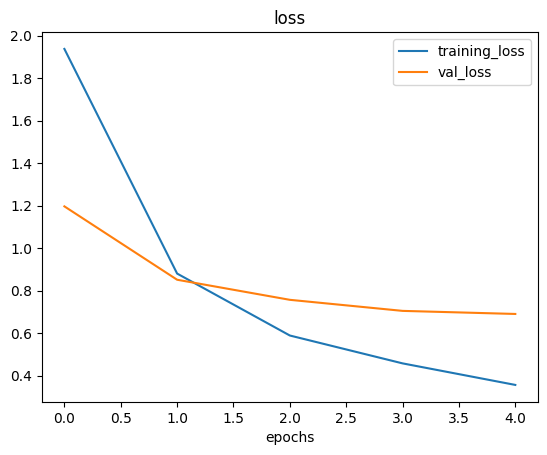

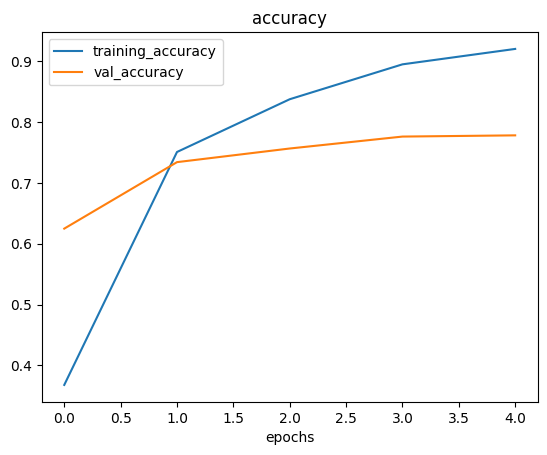

In [41]:
plot_loss_curves(resnet_history)

In [42]:
# Summary of our model ?
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


You can see the power of TensorFlow Hub here. The feature extraction layer has 23,564,800 parameters which are prelearned patterns the model has already learned on the ImageNet dataset. Since we set trainable=False, these patterns remain frozen (non-trainable) during training.

This means during training the model updates the 20,490 parameters in the output layer to suit our dataset.

Okay, we've trained a ResNetV250 model, time to do the same with EfficientNetB0 model.

The setup will be the exact same as before, except for the model_url parameter in the create_model() function and the experiment_name parameter in the create_tensorboard_callback() function.

In [45]:
# Create model
efficientnet_model= create_model(model_url = efficientnet_url, # use efficientnetb0 tensorflow hub url
                                 num_classes = train_data_10_percent.num_classes)
# Compile the model
efficientnet_model.compile(loss="categorical_crossentropy",
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=["accuracy"])
# Fit the model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data,),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])

Saving Tensorboard log files to : tensorflow_hub/efficientnetb0/20230801-140300
Epoch 1/5
24/24 [==============================] - 25s 565ms/step - loss: 1.8848 - accuracy: 0.4173 - val_loss: 1.3252 - val_accuracy: 0.7256
Epoch 2/5
24/24 [==============================] - 11s 471ms/step - loss: 1.0703 - accuracy: 0.7573 - val_loss: 0.8805 - val_accuracy: 0.8164
Epoch 3/5
24/24 [==============================] - 11s 492ms/step - loss: 0.7643 - accuracy: 0.8347 - val_loss: 0.7039 - val_accuracy: 0.8424
Epoch 4/5
24/24 [==============================] - 11s 467ms/step - loss: 0.6139 - accuracy: 0.8653 - val_loss: 0.6143 - val_accuracy: 0.8500
Epoch 5/5
24/24 [==============================] - 12s 506ms/step - loss: 0.5176 - accuracy: 0.8947 - val_loss: 0.5602 - val_accuracy: 0.8632


With a couple of lines of code we're able to leverage state of the art models and adjust them to our own use case.

Let's check out the loss curves.

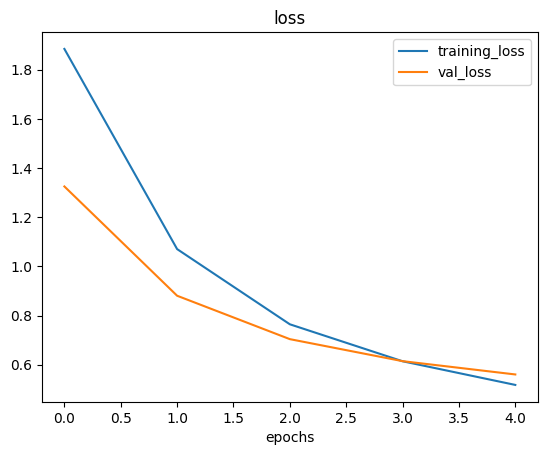

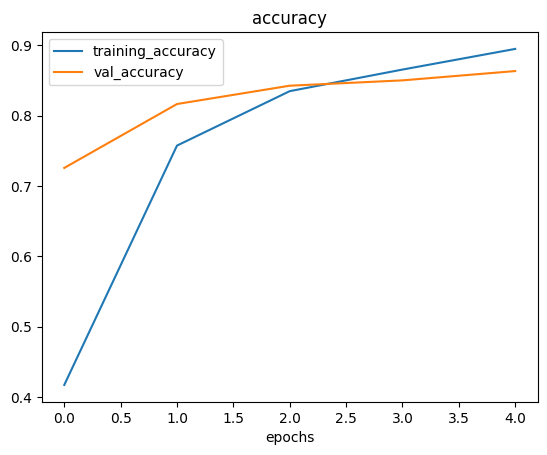

In [47]:
plot_loss_curves(efficientnet_history)

In [48]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


It seems despite having over four times less parameters (4,049,564 vs. 23,564,800) than the ResNet50V2 extraction layer, the EfficientNetB0 feature extraction layer yields better performance. Now it's clear where the "efficient" name came from.

# Comparing models uing TensorBoard


Comparing models using TensorBoard

Alright, even though we've already compared the performance of our two models by looking at the accuracy scores. But what if you had more than two models?

That's where an experiment tracking tool like TensorBoard (preinstalled in Google Colab) comes in.

The good thing is, since we set up a TensorBoard callback, all of our model's training logs have been saved automatically. To visualize them, we can upload the results to TensorBoard.dev.

Uploading your results to TensorBoard.dev enables you to track and share multiple different modelling experiments. So if you needed to show someone your results, you could send them a link to your TensorBoard.dev as well as the accompanying Colab notebook.

    🔑 Note: These experiments are public, do not upload sensitive data. You can delete experiments if needed.


In [55]:
# Upload TensorBoard  dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
--name "EfficientNetB0 vs. ResNet50V2" \
--description "Comparing two different TF Hub feature extraction models arhitectures using 10% of training images "\
--one_shot

2023-08-01 15:05:29.787838: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/NMG0syL5Qw2KPj1JpslHag/

[2023-08-01T15:05:32] Started scanning logdir.
[2023-08-01T15:05:36] Total uploaded: 60 scalars, 0 tensors, 2 binary objects (5.7 MB)
[2023-08-01T15:05:36] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/NMG0syL5Qw2KPj1JpslHag/


In [56]:
# Check out the experiments:
! tensorboard dev list

2023-08-01 15:05:46.229137: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/NMG0syL5Qw2KPj1JpslHag/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models arhitectures using 10% of training images 
	Id                   NMG0syL5Qw2KPj1JpslHag
	Created              2023-08-01 15:05:32 (16 seconds ago)
	Updated              2023-08-01 15:05:36 (12 seconds ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5938654
https://tensorboard.dev/experiment/krH6EtYcR5GW4n1IEKzcWw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models arhitectures using 10% of training images 
	Id                   krH6EtYcR5GW4n1IEKzcWw
	Created              2023-08-01 15:04:51 (57 seconds ago)
	Updated        

In [57]:
!tensorboard dev delete --experiment_id krH6EtYcR5GW4n1IEKzcWw
!tensorboard dev delete --experiment_id NMG0syL5Qw2KPj1JpslHag

2023-08-01 15:07:55.375233: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Deleted experiment krH6EtYcR5GW4n1IEKzcWw.
2023-08-01 15:08:01.310686: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Deleted experiment NMG0syL5Qw2KPj1JpslHag.


In [58]:
!tensorboard dev list

2023-08-01 15:08:24.838966: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/F74rV2KaTvGMfEUW3bVOpw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models arhitectures using 10% of training images 
	Id                   F74rV2KaTvGMfEUW3bVOpw
	Created              2023-08-01 14:32:24 (36 minutes ago)
	Updated              2023-08-01 14:32:27 (36 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5938654
Total: 1 experiment(s)
